# Ensemble Kalman Filter Tutorial

**Yan Zhan & Patricia M Gregg**

Please cite these papers if you want to use this code to publish:

*Zhan, Y., & Gregg, P. M. (2017). Data assimilation strategies for volcano geodesy. Journal of Volcanology and Geothermal Research, 344(Supplement C), 13–25. https://doi.org/10.1016/j.jvolgeores.2017.02.015*

&

*Gregg, P. M., and J. C. Pettijohn (2016), A multi-data stream assimilation framework for the assessment of volcanic unrest, Journal of Volcanology and Geothermal Research, 309, 63-77, https://doi.org/10.1016/j.jvolgeores.2015.11.008.*


## Table of Contents:

<img src="GreggZhan_Figure3_TuturialFlow.jpg" width="400" align="right">


[Part 1: Description of the EnKF Method](#Part_1)

[Part 2: Define Model Subroutines](#Part_2)

>[Part 2a: EnKF, Evensen (2003)](#Part_2a)

>[Part 2b: Mogi (1958)](#Part_2b)

>[Part 2c: McTigue (1988)](#Part_2c)

>[Part 2d: Yang et al. (1988)](#Part_2d)

[Part 3: Synthetic Data Creation](#Part_3)

>[Part 3a: Synthetic InSAR](#Part_3a)

>[Part 3b: Synthetic GPS](#Part_3b)

[Part 4: Prepare the EnKF Model](#Part_4)

[Part 5: EnKF Data Assimilation](#Part_5)

>[Part 5a: *Test 1: InSAR Data Only*](#Part_5a)

>[Part 5b: *Test 2: GPS Data Only*](#Part_5b)

>[Part 5c: *Test 3: Combined InSAR+GPS Data*](#Part_5c)

[Part 6: Extra using Yang et al. (1988)](#Part_6)

>[Part 6a: Generate Synthetic Data](#Part_6a)

>[Part 6b: EnKF Model Setup](#Part_6b)

>[Part 6c: *Test 3: Combined InSAR+GPS Data*](#Part_6c)






In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import copy

<a id='Part_1'></a>

## Part 1: Description of the EnKF Method

### Ensemble Kalman Filter Workflow

Original EnKF equations and code can be found at:

*Evensen, G. (2003). The Ensemble Kalman Filter: theoretical formulation and practical implementation. Ocean Dynamics, 53(4), 343–367. https://doi.org/10.1007/s10236-003-0036-9*

Also see: https://enkf.nersc.no, for more information.


#### The Ensemble Kalman Filter workflow adapted from Gregg and Pettijohn (2016) 

<img src="GreggZhan_Figure1_vEnKFworkflow.jpg" width="300" align="left">

**Step** **1:** Initial Ensemble Creation using a Monte Carlo approach.

**Step** **2:** Calculate the models in the ensemble to produce a Forecast Ensemble ($A$)

**Step** **3:** Combine the Forecast Ensemble ($A$) with the Measured Data ($D$) using EnKF analysis to produce the Updated Ensemble ($A_a$)

**Step** **4:** As more data become available, return to Step 2


### Ensemble Kalman Filter Analysis
#### The updated Ensemble Matrix can be expressed by 


$A_a = A + P_e H^T(H P_e H^T + R_e)^{-1} (D - H A)$

$A$: matrix holding the ensemble members

$P_e$: ensemble covariance matrix

$R_e$: measurement error covariance matrix

$H$: measurement operator relating the true model state

<img src="GreggZhan_Figure2_vEnKFmethod.png" width="600" align="left">


<a id='Part_2'></a>

## Part 2: Define Subroutines

<a id='Part_2a'></a>
### EnKF Subroutine

In [18]:
# EnKF is the ensemble Kalman Filter analysis processor with one core
# the algorithm is after Everson (2003)   
# A_EnKF = EnKF(A_EnKF = 2d array, data = 1d array, dataerr = 1d array)
# Input: A_EnKF, data, dataerr
#		"A_EnKF" = [[P1_1, P1_2, ..., P1_N],
#					[P2_1, P2_2, ..., P2_N],
#					...
#					[Pnp_1, Pnp_2, ..., Pnp_N],
#					[F1_1, F1_2, ..., F1_N],
#					[F2_1, F2_2, ..., F2_N],
#					...
#					[Fm_1, Fm_2, ..., Fm_N]]
#		in which: np = number of the parameters
#				  N  = number of ensembles
#				  m  = number of measurements
#		"data" = [d1, d2, ..., dm]
#		"dataerr" = [e1, e2, ..., em]
#
# Output: "A_EnKF"
def EnKF(A_EnKF, data, dataerr):
    # A matrix
    A = copy.deepcopy(A_EnKF)
    # Number of the measurement
    M = len(data)
    # Number of the ensemble
    N = A_EnKF.shape[1]
    # Number of the measurements + parameters
    Ndim = A_EnKF.shape[0]
    # Number of the parameters
    Np = Ndim - M

    # 1_N matrix
    OneN = np.ones([N, N]) / N

    # A bar matrix: A_bar = A OneN
    A_bar = A @ OneN
    # A' = A - A_bar
    A_prm = A - A_bar

    # H matrix
    H1 = np.zeros([Np, M])
    H2 = np.identity(M)
    H = np.vstack((H1, H2)).transpose()

    # Measurement Matrix
    d = np.kron(np.ones((N, 1)), data).transpose()

    # E-matrix: method I (using uncertainty)
    E = np.kron(np.ones((N, 1)), dataerr).transpose()

    # measurement + pertubation
    D = d + E

    # DHA = D - HA
    DHA = D - H @ A

    # HApE = HA' + E
    HApE = H @ A_prm + E

    # Singular value decomposition
    U, S, V = np.linalg.svd(HApE)
    SIGinv = (S @ S.T) ** (-1)
    
    # calculate the analysis ensemble
    X1 = SIGinv * U.transpose()
    X2 = X1 @ DHA
    X3 = U @ X2
    X4 = (H @ A_prm).transpose() @ X3
    Aa = A + A_prm @ X4

    return Aa

<a id='Part_2b'></a>

### Mogi (1958) analytical model description:

**Surface displacements can be expressed by:**

$$U_x = \frac{B (x-x_0)}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$U_y = \frac{B (y-y_0)}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$U_z = \frac{B d}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$B = a^3 dP \frac{(1 - \nu)}{\mu}$$

$$R = \sqrt{(x-x_0)^2 + (y-y_0)^2}$$

$(x_0, y_0)$: center of the chamber

$d$: depth of the chamber center

$a$: chamber radius

$dP$: overpressure along the chamber wall

$\mu$: shear modulus


### Mogi (1958) Subroutine


In [19]:
# Mogi (1958) Model
def mogi_disp(x, y, x0=0, y0=0, d=5e3, a=5e2, dP=100e6, E=30e9, nu=0.25):
    # Input
    # x: 1d array
    # y: 1d array (y = np.zeros(x.shape) if in axial-symmertic 2D model)
    # magma chamber location (x0, y0) [m]
    # magma chamber depth: d (downward posititve) [m]
    # magma chamber radius: a (always positive) [m]
    # overpressure: dP (expanding as positive) [Pa]
    # Young's Modulus: E [Pa]
    # Poisson's ration: nu [1]
    # Output
    # displacement in x, y, z direction = (du, dv, dw)

    # shear modulus
    mu = E / 2 / (1 + nu)
    # distance to the center (x0, y0)
    R = ((x - x0) ** 2 + (y - y0) ** 2) ** (1 / 2)
    # load term
    A = (1 - nu) * (a ** 3) * dP / mu
    # displacement
    du = A * (x - x0) / ((d ** 2 + R ** 2) ** (3 / 2))
    dv = A * (y - y0) / ((d ** 2 + R ** 2) ** (3 / 2))
    dw = A * d / ((d ** 2 + R ** 2) ** (3 / 2))
    return du, dv, dw

<a id='Part_2c'></a>
### McTigue (1988) Subroutine

In [20]:
# McTigue (1988) model
def mctigue_disp(x, y, x0=0, y0=0, d=5e3, a=5e2, dP=100e6, E=30e9, nu=0.25):
    # Input
    # x: 1d array
    # y: 1d array (y = np.zeros(x.shape) if in axial-symmertic 2D model)
    # magma chamber location (x0, y0) [m]
    # magma chamber depth: d (downward posititve) [m]
    # magma chamber radius: a (always positive) [m]
    # overpressure: dP (expanding as positive) [Pa]
    # Young's Modulus: E [Pa]
    # Poisson's ration: nu [1]
    # Output
    # displacement in x, y, z direction = (du, dv, dw)
    
    # shear modulus
    mu = E / 2 / (1 + nu)
    # dimensionless excess pressure (pressure/shear modulus)
    P_G = dP / mu
    # coordinates system centered in (x0,y0)
    xxn = x - x0
    yyn = y - y0
    # radial distance from source center
    r = (xxn ** 2 + yyn ** 2) ** (1/2)
    # dimensionless coordinates
    csi = xxn / d
    psi = yyn / d
    rho = r / d
    e = a / d
    # constant and expression used in the formulas 
    f1 = 1 / ((rho ** 2 + 1) ** 1.5)
    f2 = 1 / ((rho ** 2 + 1) ** 2.5)
    c1 = e ** 3 / (7 - 5 * nu)
    # displacement (dimensionless) [McTigue (1988), eq. (52) and (53)] 
    uzbar = e ** 3 * (1 - nu) * f1 * (1 - c1 * (0.5 * (1 + nu) - 3.75 * (2 - nu)/(rho ** 2 + 1)))
    urbar = rho * uzbar

    # displacement (dimensional) 
    u = urbar * P_G * d * xxn / (r + 1e-6)
    v = urbar * P_G * d * yyn / (r + 1e-6)
    w = uzbar * P_G * d
    return u, v, w

<a id='Part_2d'></a>
### Yang et al. (1988) Subroutine

Modified after Battaglia et al. (2013)

*Battaglia, M., Cervelli, P. F., & Murray, J. R. (2013). dMODELS: A MATLAB software package for modeling crustal deformation near active faults and volcanic centers. Journal of Volcanology and Geothermal Research, 254, 1–4. https://doi.org/10.1016/j.jvolgeores.2012.12.018*

Due to the length of the Yang et al. (1988) code, the full subroutine can be found in: vEnKF_Yang.py


<a id='Part_3'></a>
## Part 3: Synthetic Data Generation

#### The Mogi (1958) model is used to create a surface deformation field by varying overpressure with time. The synthetic data will become our observations in the EnKF analysis.

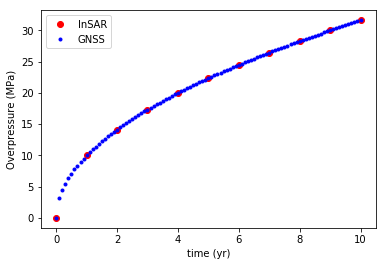

In [25]:
# time series
ti = np.linspace(0,10,11)
tg = np.linspace(0,10,101)

# Mogi source for synthetic deformation
# (x, y, z) for the point source (km)
xs = 0
ys = 0
zs = -3
# radius (km)
rs = 2
# overpressure trajectory (MPa) InSAR
OPi = ti ** (1/2) * 10
# overpressure trajectory (MPa) GNSS
OPg = tg ** (1/2) * 10

# material properties
E = 30e9
nu = 0.25

# plot the overpressure trajectory
plt.plot(ti, OPi, 'ro', label='InSAR')
plt.plot(tg, OPg, 'b.', label='GNSS')
plt.xlabel('time (yr)')
plt.ylabel('Overpressure (MPa)')
plt.legend()
plt.savefig('OverpressureSynthetic.pdf')
plt.show()

# X, Y grid
X_InSAR, Y_InSAR = np.meshgrid(np.linspace(-5e3,5e3,51), np.linspace(-5e3,5e3,51))
# number of measurements
nobs = len(X_InSAR.reshape(-1))


<a id='Part_3a'></a>
### Create a synthetic LOS displacement (InSAR) dataset:

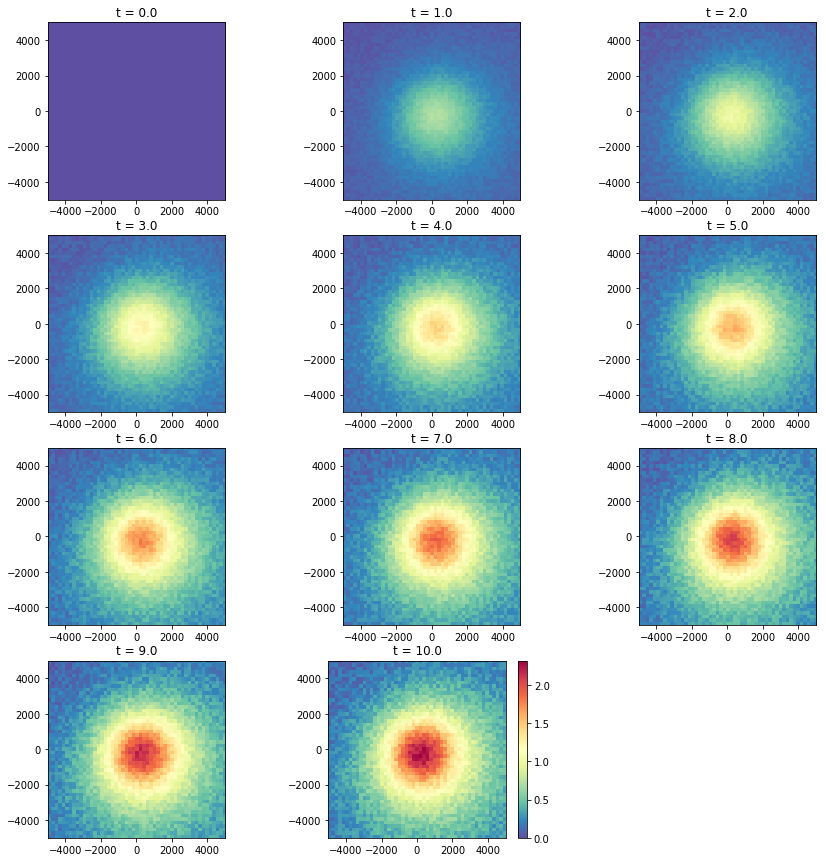

In [33]:
# allocate the measurements
LOS_disp = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])
Uncen = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])

# define the looking angle
theta = 45 * np.pi / 180
phi = 23 * np.pi / 180
lkag = [np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)]

# calcualte the displacement
for i in np.arange(0, len(ti)):
    Um, Vm, Wm = mctigue_disp(X_InSAR, Y_InSAR,
                           x0=xs*1e3, y0=ys*1e3,
                           d=-zs*1e3, a=rs*1e3, 
                           dP=OPi[i]*1e6, E=E, nu=nu
                          )
    
    disp = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]
    random_error = np.random.rand(X_InSAR.shape[0], X_InSAR.shape[1]) * disp.max() * 0.1
    Uncen[:, :, i] = random_error
    LOS_disp[:, :, i] = disp + random_error
    cmax = LOS_disp[:, :, i].max()

## reformat the dataset for EnKF
# convert measurement location to 1d array
x_InSAR = X_InSAR.reshape(-1)
y_InSAR = Y_InSAR.reshape(-1)
# convert measurement and error to 1d array
dat_InSAR = np.zeros([nobs, len(ti)])
err_InSAR = np.zeros([nobs, len(ti)])
# reformat
for i in np.arange(0, len(ti)):
    dat_InSAR[:, i] = LOS_disp[:,:,i].reshape(-1)
    err_InSAR[:, i] = Uncen[:,:,i].reshape(-1)
    
# plot synthetic InSAR data
plt.figure(2, figsize=(15,15))
for i in np.arange(0, len(ti)):
    plt.subplot(4,3,i+1)
    plt.imshow(LOS_disp[:,:,i],
              extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
              vmin=0, vmax=cmax,
              cmap=cm.Spectral_r)
    plt.title('t = {}'.format(ti[i]))
plt.colorbar()
plt.savefig('SyntheticInSAR.pdf')
plt.show()

<a id='Part_3b'></a>
### Create a synthetic GNSS-GPS dataset for an assumed number of stations placed at random locations:

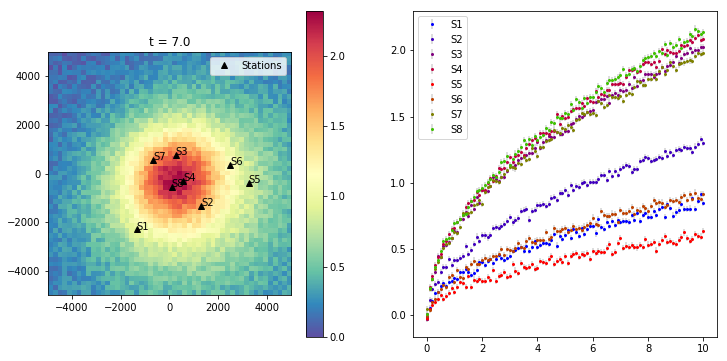

In [36]:
# number of stations
NStation = 8
# generate random location of GNSS stations
x_GNSS = np.random.standard_normal(NStation) * 2e3
y_GNSS = np.random.standard_normal(NStation) * 2e3

# plot location of the GNSS stations
plt.figure(6, figsize=(12,6))
plt.subplot(121)
plt.plot(x_GNSS, y_GNSS, 'k^', label='Stations')
for i in np.arange(0, NStation):
    plt.text(x_GNSS[i], y_GNSS[i], "S{}".format(i+1))
plt.imshow(LOS_disp[:,:,-1],
           extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
           vmin=0, vmax=cmax,
           cmap=cm.Spectral_r)
plt.title('t = {}'.format(ti[i]))
plt.colorbar()
plt.legend()

# allocate the measurements
Gx = np.zeros([NStation, len(tg)])
Gy = np.zeros([NStation, len(tg)])
Gz = np.zeros([NStation, len(tg)])
# uncertainty of GNSS
sx0 = cmax * 1e-3 * 5
sy0 = sx0
sz0 = sx0 * 2
# Error data of GNSS
Sx = np.ones([NStation, len(tg)]) * sx0
Sy = np.ones([NStation, len(tg)]) * sy0
Sz = np.ones([NStation, len(tg)]) * sz0

# calcualte the displacement
for i in np.arange(0, len(tg)):
    Um, Vm, Wm = mctigue_disp(x_GNSS, y_GNSS,
                           x0=xs*1e3, y0=ys*1e3,
                           d=-zs*1e3, a=rs*1e3, 
                           dP=OPg[i]*1e6, E=E, nu=nu
                          )
    Gx[:, i] = Um + np.random.standard_normal(NStation) * sx0
    Gy[:, i] = Vm + np.random.standard_normal(NStation) * sy0
    Gz[:, i] = Wm + np.random.standard_normal(NStation) * sz0
    
plt.subplot(122)
cmap = cm.get_cmap('brg')
for i in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[i, :],
                 yerr=Sz[i, :],
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(i/NStation),
                 markeredgecolor=cmap(i/NStation),
                 label='S{}'.format(i+1)
                )
plt.legend()
plt.savefig('SyntheticGPS.pdf')
plt.show()
    

### Combine InSAR and GNSS-GPS data to prepare for EnKF Analysis

In [38]:
# uniform timeseries
tu = np.sort(np.unique(np.hstack([ti, tg])))

# allocate data dict
DATA = {"x": [],
        "y": [],
        "typ": [],
        "ddvx": [],
        "ddvy": [],
        "ddvz": [],
        "dat": [],
        "err": []
       }

# do for all time steps
for i in np.arange(0, len(tu)):
    LOCx = []
    LOCy = []
    Type = []
    DDVx = []
    DDVy = []
    DDVz = []
    data = []
    erro = []
    
    # if there is InSAR data
    if tu[i] in ti:
        # append location
        LOCx = np.hstack([LOCx, x_InSAR])
        LOCy = np.hstack([LOCy, y_InSAR])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(x_InSAR.shape)])
        # looking angle
        DDVx = np.hstack([DDVx, np.ones(x_InSAR.shape) * lkag[0]])
        DDVy = np.hstack([DDVy, np.ones(x_InSAR.shape) * lkag[1]])
        DDVz = np.hstack([DDVz, np.ones(x_InSAR.shape) * lkag[2]])
        # find InSAR data and error
        ii = np.where(ti == tu[i])[0][0]
        data = np.hstack([data, dat_InSAR[:, ii]])
        erro = np.hstack([erro, err_InSAR[:, ii]])
        
    # if there is GNSS data
    if tu[i] in tg:
        # append location
        LOCx = np.hstack([LOCx, x_GNSS, x_GNSS, x_GNSS])
        LOCy = np.hstack([LOCy, y_GNSS, y_GNSS, y_GNSS])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(len(x_GNSS) * 3) + 1])
        # looking angle (E=[1,0,0], N=[0,1,0], U=[0,0,1])
        DDVx = np.hstack([DDVx, np.ones(len(x_GNSS)), np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVy = np.hstack([DDVy, np.zeros(len(x_GNSS)), np.ones(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVz = np.hstack([DDVz, np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS)), np.ones(len(x_GNSS))])
        # find GNSS data and error
        ig = np.where(tg == tu[i])[0][0]
        data = np.hstack([data, Gx[:, ig]])
        data = np.hstack([data, Gy[:, ig]])
        data = np.hstack([data, Gz[:, ig]])
        erro = np.hstack([erro, Sx[:, ig]])
        erro = np.hstack([erro, Sy[:, ig]])
        erro = np.hstack([erro, Sz[:, ig]])

    # storing data
    DATA["x"].append(LOCx)
    DATA["y"].append(LOCy)   
    DATA["typ"].append(Type)
    DATA["ddvx"].append(DDVx)
    DATA["ddvy"].append(DDVy)
    DATA["ddvz"].append(DDVz)
    DATA["dat"].append(data)
    DATA["err"].append(erro)
    
    # print status
    print("t={}, x={}, typ={}, ddv={}, dat={}, err={}".format(tu[i],
                                                             len(LOCx),
                                                             len(Type),
                                                             len(DDVx),
                                                             len(data),
                                                             len(erro)))

t=0.0, x=2625, typ=2625, ddv=2625, dat=2625, err=2625
t=0.1, x=24, typ=24, ddv=24, dat=24, err=24
t=0.2, x=24, typ=24, ddv=24, dat=24, err=24
t=0.30000000000000004, x=24, typ=24, ddv=24, dat=24, err=24
t=0.4, x=24, typ=24, ddv=24, dat=24, err=24
t=0.5, x=24, typ=24, ddv=24, dat=24, err=24
t=0.6000000000000001, x=24, typ=24, ddv=24, dat=24, err=24
t=0.7000000000000001, x=24, typ=24, ddv=24, dat=24, err=24
t=0.8, x=24, typ=24, ddv=24, dat=24, err=24
t=0.9, x=24, typ=24, ddv=24, dat=24, err=24
t=1.0, x=2625, typ=2625, ddv=2625, dat=2625, err=2625
t=1.1, x=24, typ=24, ddv=24, dat=24, err=24
t=1.2000000000000002, x=24, typ=24, ddv=24, dat=24, err=24
t=1.3, x=24, typ=24, ddv=24, dat=24, err=24
t=1.4000000000000001, x=24, typ=24, ddv=24, dat=24, err=24
t=1.5, x=24, typ=24, ddv=24, dat=24, err=24
t=1.6, x=24, typ=24, ddv=24, dat=24, err=24
t=1.7000000000000002, x=24, typ=24, ddv=24, dat=24, err=24
t=1.8, x=24, typ=24, ddv=24, dat=24, err=24
t=1.9000000000000001, x=24, typ=24, ddv=24, dat=24, e

<a id='Part_4'></a>
## Part 4: Prepare the models for EnKF Analysis

#### Define the number of ensemble and number of iterations

In [39]:
# number of ensemble
nens = 300
# number of iteration
nitr = 5

#### Figure 1: EnKF Flow Chart Step 1: Initial Ensemble Creation

The initial ensemble creates of suite of parameters based on a best guess or *a priori* information. The initial guess does not affect the final result, if you have enough iterations.


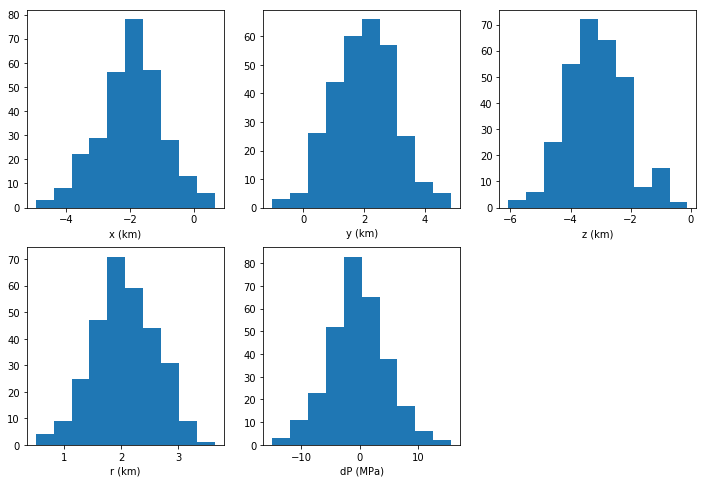

In [42]:
# number of the parameters
npar = 5
# Initial parameter guess
# point source location
# x (km)
xc0 = np.random.standard_normal(nens) * 1 + -2
# y (km)
yc0 = np.random.standard_normal(nens) * 1 + 2
# z (km)
zc0 = np.random.standard_normal(nens) * 1 - 3
# radius (km)
rc0 = np.random.standard_normal(nens) * 0.5 + 2
# overpressure (MPa)
dp0 = np.random.standard_normal(nens) * 5 + 0

## Plot initial ensemble parameter
plt.figure(3,figsize=(12,8))
plt.subplot(231)
plt.hist(xc0)
plt.xlabel('x (km)')
plt.subplot(232)
plt.hist(yc0)
plt.xlabel('y (km)')
plt.subplot(233)
plt.hist(zc0)
plt.xlabel('z (km)')
plt.subplot(234)
plt.hist(rc0)
plt.xlabel('r (km)')
plt.subplot(235)
plt.hist(dp0)
plt.xlabel('dP (MPa)')
plt.savefig('InitialEnsemble.pdf')
plt.show()

<a id='Part_5'></a>
## Part 5: Data assimilation using EnKF analysis 

**Step 1.** Load data and uncertainty (i.e., synthetic InSAR-like data)

**Step 2.** Calculate forecast ensemble using chosen modeling approach (e.g., Mogi model)

**Step 3.** EnKF analysis (*Aa = A + K(D - HA)*)

**Step 4.** Update parameter for the model using chosen modeling approach (e.g., Mogi model)

**Step 5.** Go to **Step 2** within iterations; Go to **Step 1** if iterations end; **End** if no new data. 

We have provided 3 tests below: (1) Assimilation of InSAR data only; (2) Assimilation of GPS data only; and (3) Combined assimilation of both InSAR and GPS data.

<a id='Part_5a'></a>
## *Test 1: InSAR data only*

In [43]:
# number of measurements
nobs = len(X_InSAR.reshape(-1))
# allocate the A matrix
A = np.zeros([npar + nobs, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = rc0
A[4, :] = dp0

# allocate the root mean square error
RMSE = np.zeros([len(ti), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(ti)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]

# for all time steps
for step in np.arange(1, len(ti)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = dat_InSAR[:, step]
    Err = err_InSAR[:, step]
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            Um, Vm, Wm = mctigue_disp(x_InSAR, y_InSAR,
                                   x0=A[0, i]*1e3, y0=A[1, i]*1e3,
                                   d=-A[2, i]*1e3, a=A[3, i]*1e3, 
                                   dP=A[4, i]*1e6, E=E, nu=nu
                                  )
            # calculate the LOS displacement
            LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]
            # store the data into A matrix
            A[npar:npar+nobs, i] = LOS_model
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((LOS_model - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    
print('All done')

step = 1
RMSE = 17.927600645500245
RMSE = 0.493905233468136
RMSE = 0.35567610783590037
RMSE = 0.2918918494513282
RMSE = 0.260506252758246
step = 2
RMSE = 0.3271481647547185
RMSE = 0.3075514092417365
RMSE = 0.29023356816287665
RMSE = 0.28531034561622337
RMSE = 0.26050742902173196
step = 3
RMSE = 0.7862362057954647
RMSE = 0.29568422168930186
RMSE = 0.25935453644833056
RMSE = 0.22316168504628558
RMSE = 0.18887363659128023
step = 4
RMSE = 0.2036022602602907
RMSE = 0.17562170722709364
RMSE = 0.15463799040557558
RMSE = 0.13843949382463033
RMSE = 0.12582714720254334
step = 5
RMSE = 0.1559962547923726
RMSE = 0.14553826367723247
RMSE = 0.13677913354926763
RMSE = 0.12947565057867536
RMSE = 0.12335195053160992
step = 6
RMSE = 0.15797250889289208
RMSE = 0.1524270201587289
RMSE = 0.14743303748676903
RMSE = 0.14254738754543503
RMSE = 0.13802465057511146
step = 7
RMSE = 0.17684495531848843
RMSE = 0.17123858430479358
RMSE = 0.16477386035722827
RMSE = 0.15764785271277618
RMSE = 0.14908345782589957
step

### Compare model results to InSAR data (InSAR only)

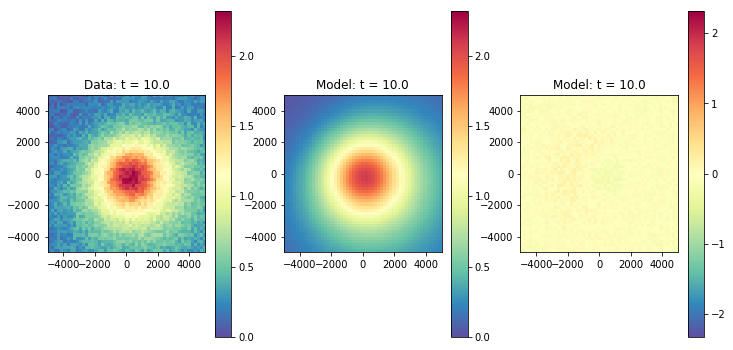

In [44]:
# select step
step = -1

# calculate the last step of the model
Um, Vm, Wm = mctigue_disp(X_InSAR, Y_InSAR,
                       x0=np.mean(param_est[0, :, step])*1e3, y0=np.mean(param_est[1, :, step])*1e3,
                       d=-np.mean(param_est[2, :, step])*1e3, a=np.mean(param_est[3, :, step])*1e3, 
                       dP=np.mean(param_est[4, :, step])*1e6, E=E, nu=nu
                      )
# calculate the LOS displacement
LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]

# Plot data
plt.figure(6, figsize=(12,6))
plt.subplot(131)
plt.imshow(LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Data: t = {}'.format(ti[step]))

# Plot model
plt.subplot(132)
plt.imshow(LOS_model,
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))

# Plot misfit
plt.subplot(133)
plt.imshow(LOS_model - LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=-cmax, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))
plt.savefig('InSARComparison.pdf')
plt.show()

### Plot RMSE vs time (InSAR only)

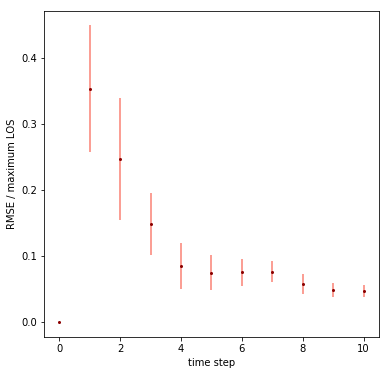

In [45]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=ti, y=np.mean(RMSE[:, :], axis=1) / (np.max(dat_InSAR, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(dat_InSAR, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.savefig('RMSE_InSAROnly.pdf')
plt.show()

###  EnKF Estimation of source locations (InSAR only)

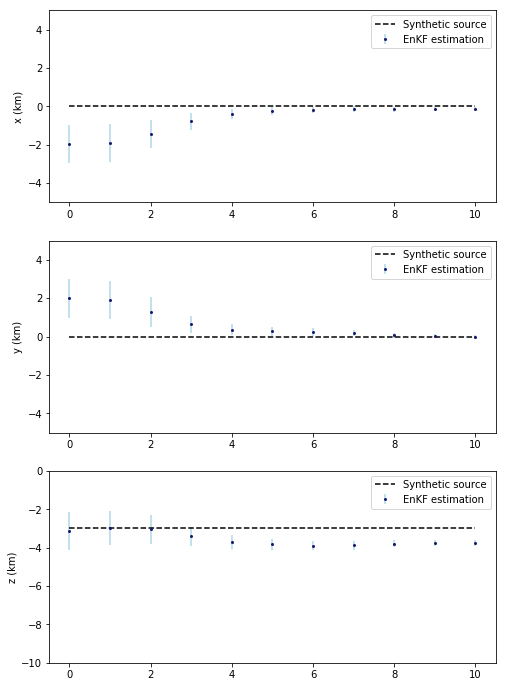

In [46]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                  np.ones(ti.shape) * rs,
                  OPi]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=ti, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
    plt.savefig('ParameterEst_InSAROnly.pdf')
plt.show()


### Radius and Overpressure estimations (InSAR only)

Note that a major issue with the elastic analytical approach is the non-uniqueness of the model and the inability to uniquely solve for radius and overpressure. We will investigate volume change in the next section.

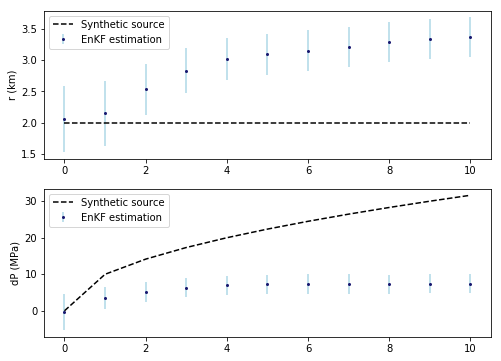

In [47]:
plt.figure(5, figsize=(8,6))
y_label = ['r (km)', 'dP (MPa)']
for par in np.arange(3, 5):
    # plot parameter estimation
    plt.subplot(2,1,par-2)
    plt.errorbar(x=ti, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
plt.savefig('RdP_InSAROnly.pdf')    
plt.show()

### Volume change (InSAR only)

#### Non-Unique issue

As mentioned above Mogi source is a point source, so that the radius and pressure cannot be determined uniquely. As such, volume change provides a better fit with the synthetic.

**Mogi source:**

$$U_x = \frac{B (x-x_0)}{(d^2 + R^2)^ {\frac{3}{2}}}$$

$$...$$

$$B = a^3 dP \frac{(1 - \nu)}{\mu}$$

$$V = \frac{4 \pi a^3}{3}$$

$$a^3 = \frac{3 V}{4 \pi}$$

$$dP = \frac{\Delta V}{V} K $$

$$B = \frac{3 V}{4 \pi} \frac{\Delta V}{V} \frac{(1 - \nu)}{\mu} = C \Delta V$$

$$\Delta V = \frac{dP V}{K} = a^3 dP \frac{4 \pi}{3 K}$$

#### Volume change

Volume change as a combination of raidus and overpressure can be determined unqiuely.


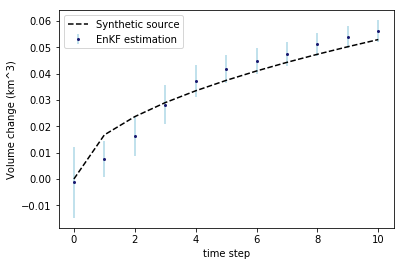

In [48]:
## calculate the volume change of models
am = param_est[3, :, :] * 1e3
dPm = param_est[4, :, :] * 1e6
K = E / 3 / (1 - 2 * nu)
dVm = am ** 3 * dPm * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = (rs*1e3) ** 3 * (OPi*1e6) * 4 * np.pi / 3 / K

# plot
plt.plot(ti, dVs / 1e9, 'k--', label='Synthetic source')
plt.errorbar(x=ti, y=np.mean(dVm, axis=0) / 1e9,
             yerr=np.std(dVm, axis=0) / 1e9,
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation'
            )

plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.savefig('dV_InSARonly.pdf')
plt.show()

<a id='Part_5b'></a>
## *Test 2: GPS data only*

In [49]:
nobs = NStation * 3
# allocate the A matrix
A = np.zeros([npar + nobs, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = rc0
A[4, :] = dp0

# allocate the root mean square error
RMSE = np.zeros([len(tg), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(tg)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]
GNSS_res_avg = np.zeros([len(tg), NStation * 3])
GNSS_res_std = np.zeros([len(tg), NStation * 3])

# for all time steps
for step in np.arange(1, len(tg)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = np.hstack([Gx[:, step], Gy[:, step], Gz[:, step]])
    Err = np.hstack([Sx[:, step], Sy[:, step], Sz[:, step]])
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        
        # calculate forecast ensemble using McTigue (Step 2)
        for i in np.arange(0, nens):
            Um, Vm, Wm = mctigue_disp(x_GNSS, y_GNSS,
                                   x0=A[0, i]*1e3, y0=A[1, i]*1e3,
                                   d=-A[2, i]*1e3, a=A[3, i]*1e3, 
                                   dP=A[4, i]*1e6, E=E, nu=nu
                                  )
            
            # store the data into A matrix
            A[npar:npar+nobs, i] = np.hstack([Um, Vm, Wm])
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((np.hstack([Um, Vm, Wm]) - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    GNSS_res_avg[step, :] = np.mean(A[npar:npar+nobs, :], axis=1)
    GNSS_res_std[step, :] = np.std(A[npar:npar+nobs, :], axis=1)
    
print('All done')

step = 1
RMSE = 0.31736390624898264
RMSE = 0.16802397346714354
RMSE = 0.13151932428872795
RMSE = 0.10242065329437935
RMSE = 0.12821145334518602
step = 2
RMSE = 0.11701191325166353
RMSE = 0.12521907623714598
RMSE = 0.10479360984896156
RMSE = 0.09212664326006188
RMSE = 0.08609255825930504
step = 3
RMSE = 0.10493033264794706
RMSE = 0.0919404627018431
RMSE = 0.07607431208429513
RMSE = 0.07140450386533956
RMSE = 0.06320954246707239
step = 4
RMSE = 0.07159147978209948
RMSE = 0.059230703886522205
RMSE = 0.051893326079027184
RMSE = 0.042387227858945
RMSE = 0.03573747738630214
step = 5
RMSE = 0.04387554699704514
RMSE = 0.036768565432020534
RMSE = 0.032690691486090384
RMSE = 0.029372464825953355
RMSE = 0.031097478230794097
step = 6
RMSE = 0.03441310080985153
RMSE = 0.028522386467724613
RMSE = 0.02477729994238949
RMSE = 0.02402156615739501
RMSE = 0.02348217808256736
step = 7
RMSE = 0.018449748051024693
RMSE = 0.020262892625472574
RMSE = 0.020684245897483973
RMSE = 0.02096328458121237
RMSE = 0.021

RMSE = 0.05915106379515617
RMSE = 0.05817442179833962
RMSE = 0.05722085894402073
step = 58
RMSE = 0.062403086197759874
RMSE = 0.061324582382200156
RMSE = 0.06029683061941584
RMSE = 0.05930060668719873
RMSE = 0.05833142086593616
step = 59
RMSE = 0.06334158615815816
RMSE = 0.062295722466985025
RMSE = 0.06129338243637333
RMSE = 0.060320532873712335
RMSE = 0.059373637066896044
step = 60
RMSE = 0.05906487489563941
RMSE = 0.058089774070464034
RMSE = 0.05711932122198866
RMSE = 0.056167855230657815
RMSE = 0.05523900428481159
step = 61
RMSE = 0.07096066707758981
RMSE = 0.07005944420807533
RMSE = 0.06912777410346387
RMSE = 0.06820761477348851
RMSE = 0.06730739506902082
step = 62
RMSE = 0.07535504979555582
RMSE = 0.07431747460837994
RMSE = 0.07316940908576881
RMSE = 0.07202797026575834
RMSE = 0.07090895748343738
step = 63
RMSE = 0.07420699587141724
RMSE = 0.07308057975255183
RMSE = 0.07195138325389223
RMSE = 0.07084208879545556
RMSE = 0.06975626254399156
step = 64
RMSE = 0.06497682367106299
RMSE 

### RMSE (GPS only)

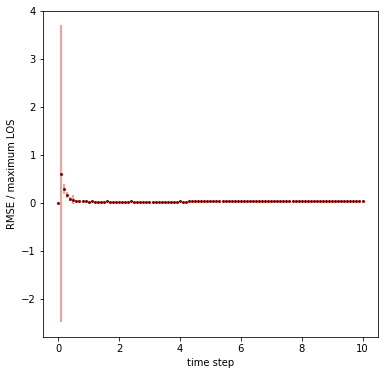

In [50]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=tg, y=np.mean(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.savefig('RMSE_GPSonly.pdf')
plt.show()

### Model-data comparison (GPS Only)

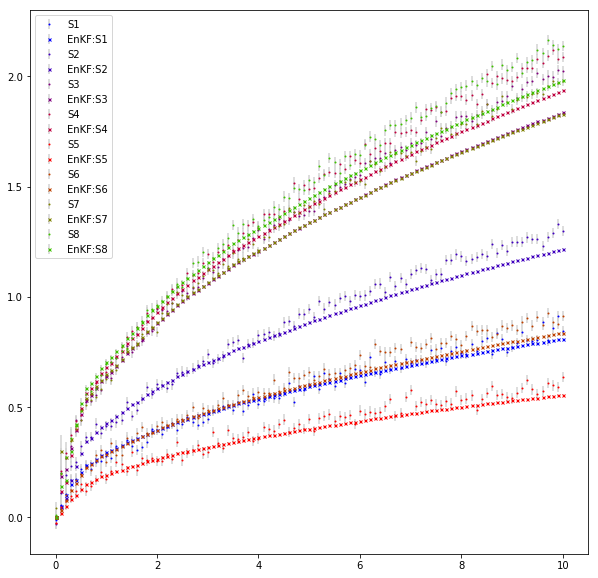

In [51]:
plt.figure(10, figsize=(10,10))
for istation in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[istation, :],
                 yerr=Sz[istation, :],
                 marker='o', markersize=1,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='S{}'.format(istation+1)
                )

    plt.errorbar(x=tg, 
                 y=GNSS_res_avg[:, istation + NStation * 2],
                 yerr=GNSS_res_std[:, istation + NStation * 2],
                 marker='x', markersize=3,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='EnKF:S{}'.format(istation+1)
                )

plt.legend()
plt.savefig('DataComparison_GPSonly.pdf')
plt.show()
    

### Location of the chamber (GPS only)

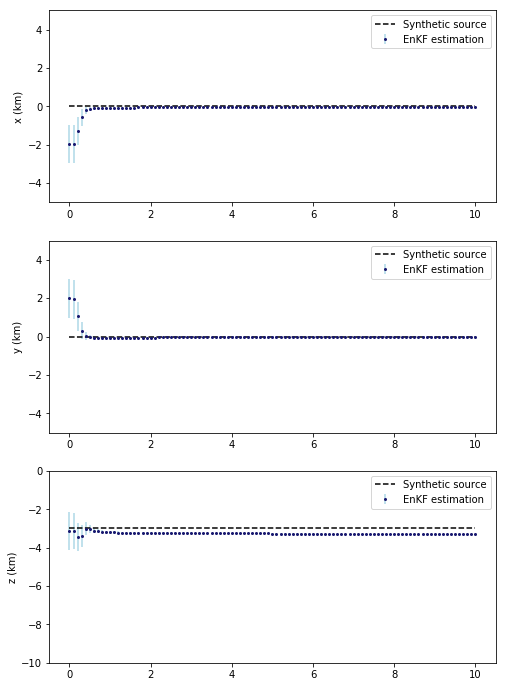

In [52]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                  np.ones(ti.shape) * rs,
                  OPi]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=tg, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
    plt.savefig('ParameterEst_GPSonly.pdf')
plt.show()



### Radius and overpressure (GPS only)

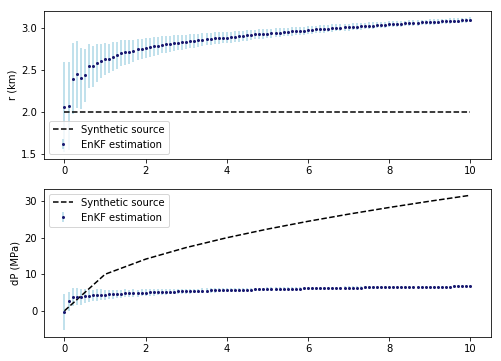

In [53]:
plt.figure(5, figsize=(8,6))
y_label = ['r (km)', 'dP (MPa)']
for par in np.arange(3, 5):
    # plot parameter estimation
    plt.subplot(2,1,par-2)
    plt.errorbar(x=tg, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
plt.savefig('RdP_GPSonly.pdf')    
plt.show()

### Volume change (GPS only)

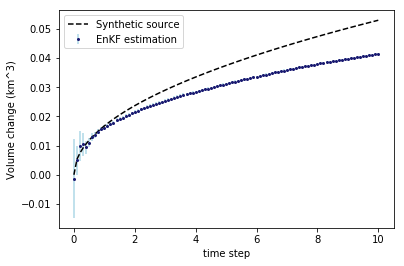

In [54]:
## calculate the volume change of models
am = param_est[3, :, :] * 1e3
dPm = param_est[4, :, :] * 1e6
K = E / 3 / (1 - 2 * nu)
dVm = am ** 3 * dPm * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = (rs*1e3) ** 3 * (OPg*1e6) * 4 * np.pi / 3 / K

# plot
plt.plot(tg, dVs / 1e9, 'k--', label='Synthetic source')
plt.errorbar(x=tg, y=np.mean(dVm, axis=0) / 1e9,
             yerr=np.std(dVm, axis=0) / 1e9,
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation'
            )
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.savefig('dV_GPSonly.pdf')
plt.show()

<a id='Part_5c'></a>
## *Test 3: Combined InSAR and GPS data*

In [55]:
# allocate the A matrix
A = np.zeros([npar, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = rc0
A[4, :] = dp0

# allocate the root mean square error
RMSE = np.zeros([len(tu), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(tu)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]

GNSS_res_avg = np.zeros([len(tg), NStation * 3])
GNSS_res_std = np.zeros([len(tg), NStation * 3])

# for all time steps
for step in np.arange(1, len(tu)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = DATA['dat'][step]
    Err = DATA['err'][step]
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        # allocate A matrix result part
        A_res = np.zeros([len(Dat), nens])
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            Um, Vm, Wm = mctigue_disp(DATA['x'][step], DATA['y'][step],
                                   x0=A[0, i]*1e3, y0=A[1, i]*1e3,
                                   d=-A[2, i]*1e3, a=A[3, i]*1e3, 
                                   dP=A[4, i]*1e6, E=E, nu=nu
                                  )

            # store the data into A matrix
            A_res[:, i] = Um * DATA['ddvx'][step] + Vm * DATA['ddvy'][step] + Wm * DATA['ddvz'][step]
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((A_res[:, i] - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        A = np.vstack([A[0:npar], A_res])
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    if tu[step] in tg:
        ig = np.where(tg == tu[step])[0][0]
        GNSS_res_avg[ig, :] = np.mean(A_res[DATA['typ'][step]==2, :], axis=1)
        GNSS_res_std[ig, :] = np.std(A_res[DATA['typ'][step]==2, :], axis=1)

print('All done')

step = 1
RMSE = 0.31736390624898264
RMSE = 0.16802397346714354
RMSE = 0.13151932428872795
RMSE = 0.10242065329437935
RMSE = 0.12821145334518602
step = 2
RMSE = 0.11701191325166353
RMSE = 0.12521907623714598
RMSE = 0.10479360984896156
RMSE = 0.09212664326006188
RMSE = 0.08609255825930504
step = 3
RMSE = 0.10493033264794706
RMSE = 0.0919404627018431
RMSE = 0.07607431208429513
RMSE = 0.07140450386533956
RMSE = 0.06320954246707239
step = 4
RMSE = 0.07159147978209948
RMSE = 0.059230703886522205
RMSE = 0.051893326079027184
RMSE = 0.042387227858945
RMSE = 0.03573747738630214
step = 5
RMSE = 0.04387554699704514
RMSE = 0.036768565432020534
RMSE = 0.032690691486090384
RMSE = 0.029372464825953355
RMSE = 0.031097478230794097
step = 6
RMSE = 0.03441310080985153
RMSE = 0.028522386467724613
RMSE = 0.02477729994238949
RMSE = 0.02402156615739501
RMSE = 0.02348217808256736
step = 7
RMSE = 0.018449748051024693
RMSE = 0.020262892625472574
RMSE = 0.020684245897483973
RMSE = 0.02096328458121237
RMSE = 0.021

RMSE = 0.059329118020551255
RMSE = 0.058241740406028274
RMSE = 0.057190473169634104
RMSE = 0.05617089275086196
step = 59
RMSE = 0.061104974652607474
RMSE = 0.06000277215006894
RMSE = 0.05895133454285487
RMSE = 0.05793388402909263
RMSE = 0.05694677888278709
step = 60
RMSE = 0.11828072401280655
RMSE = 0.1181633796120428
RMSE = 0.11804672195505847
RMSE = 0.1179307258349918
RMSE = 0.1178153673069826
step = 61
RMSE = 0.0726925382835106
RMSE = 0.07175096294006411
RMSE = 0.07067374925842657
RMSE = 0.06960893100467243
RMSE = 0.06857113814254275
step = 62
RMSE = 0.07628148276923204
RMSE = 0.07509429470515522
RMSE = 0.07376238030447996
RMSE = 0.07245789355226107
RMSE = 0.07118549312765551
step = 63
RMSE = 0.07437887291145356
RMSE = 0.07310728026350008
RMSE = 0.0718313249785336
RMSE = 0.07058374898718321
RMSE = 0.06936669001685958
step = 64
RMSE = 0.06449330223447768
RMSE = 0.0632964430261255
RMSE = 0.06225526604871675
RMSE = 0.06127013690364464
RMSE = 0.06031840496452595
step = 65
RMSE = 0.07027

### RMSE (InSAR + GNSS)

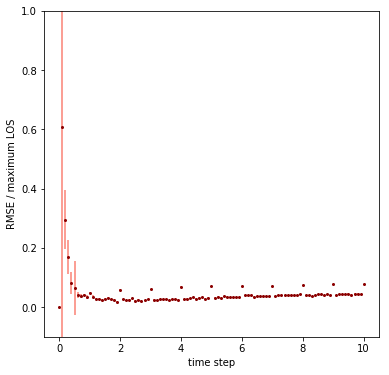

In [63]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.ylim(-0.1,1.0)
plt.errorbar(x=tu, y=np.mean(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.savefig('RMSE_GPS+InSAR.pdf')
plt.show()

### GNSS results (InSAR + GNSS)

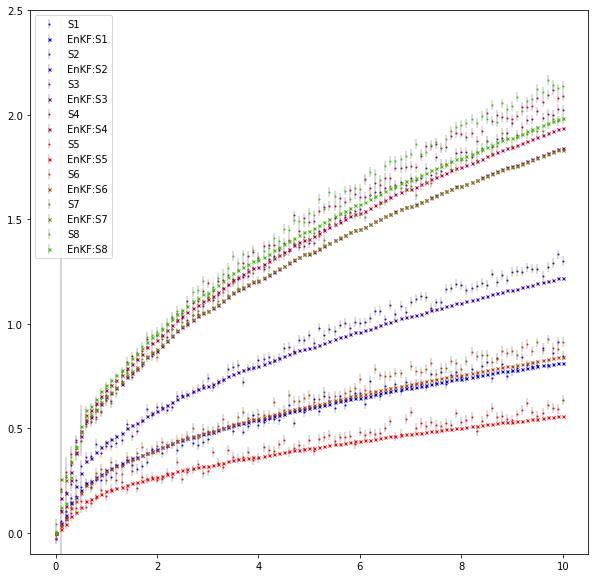

In [65]:
plt.figure(10, figsize=(10,10))
plt.ylim(-0.1,2.5)
for istation in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[istation, :],
                 yerr=Sz[istation, :],
                 marker='o', markersize=1,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='S{}'.format(istation+1)
                )

    plt.errorbar(x=tg, 
                 y=GNSS_res_avg[:, istation + NStation * 2],
                 yerr=GNSS_res_std[:, istation + NStation * 2],
                 marker='x', markersize=3,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='EnKF:S{}'.format(istation+1)
                )

plt.legend()
plt.savefig('GPScompare_GPS+InSAR.pdf')
plt.show()

### InSAR results (InSAR + GNSS)

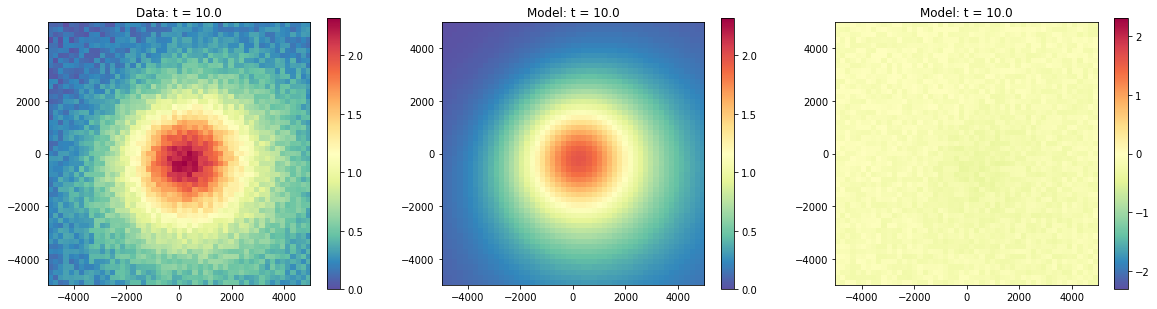

In [72]:
# select step
step = -1

# calculate the last step of the model
Um, Vm, Wm = mctigue_disp(X_InSAR, Y_InSAR,
                       x0=np.mean(param_est[0, :, step])*1e3, y0=np.mean(param_est[1, :, step])*1e3,
                       d=-np.mean(param_est[2, :, step])*1e3, a=np.mean(param_est[3, :, step])*1e3, 
                       dP=np.mean(param_est[4, :, step])*1e6, E=E, nu=nu
                      )
# calculate the LOS displacement
LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]

# Plot data
plt.figure(6, figsize=(20,5))
plt.subplot(131)
plt.imshow(LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Data: t = {}'.format(ti[step]))

# Plot model
plt.subplot(132)
plt.imshow(LOS_model,
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))

# Plot misfit
plt.subplot(133)
plt.imshow(LOS_model - LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=-cmax, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))
plt.savefig('InSARcompare_GPS+InSAR.pdf')
plt.show()

### Location of the chamber (InSAR + GNSS)

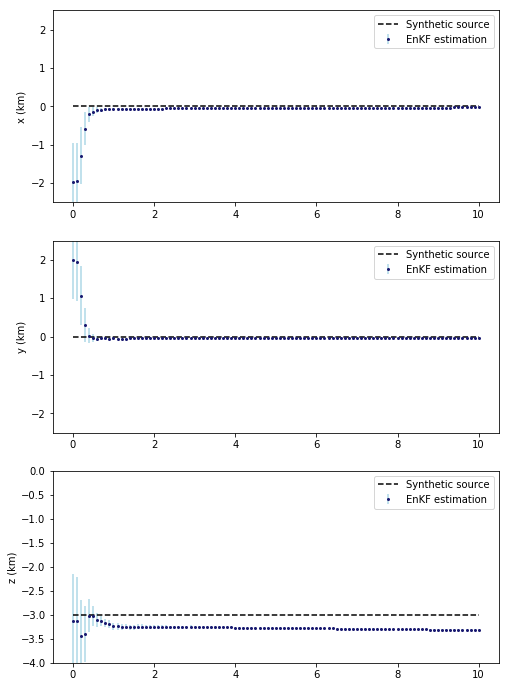

In [74]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                  np.ones(ti.shape) * rs,
                  OPi]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-2.5,2.5])
    else:
        plt.ylim([-4, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
    plt.savefig('ParEst_GPS+InSAR.pdf')
plt.show()

### Radius and Overpressure (InSAR + GNSS)

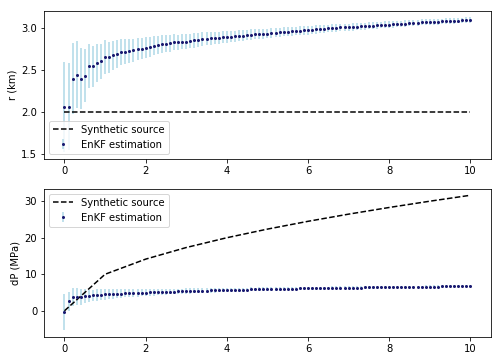

In [68]:
plt.figure(5, figsize=(8,6))
y_label = ['r (km)', 'dP (MPa)']
for par in np.arange(3, 5):
    # plot parameter estimation
    plt.subplot(2,1,par-2)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
plt.savefig('RdP_GPS+InSAR.pdf')    
plt.show()

### Volume change (InSAR + GNSS)

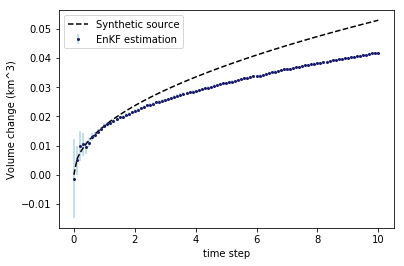

In [69]:
## calculate the volume change of models
am = param_est[3, :, :] * 1e3
dPm = param_est[4, :, :] * 1e6
K = E / 3 / (1 - 2 * nu)
dVm = am ** 3 * dPm * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = (rs*1e3) ** 3 * (OPg*1e6) * 4 * np.pi / 3 / K

# plot
plt.plot(tg, dVs / 1e9, 'k--', label='Synthetic source')
plt.errorbar(x=tu, y=np.mean(dVm, axis=0) / 1e9,
             yerr=np.std(dVm, axis=0) / 1e9,
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation'
            )
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.savefig('dV_GPS+InSAR.pdf')
plt.show()

<a id='Part_6'></a>
# II) Ellipsoid model (Yang et al., 1988)

Modified after Battaglia et al. (2013)

Battaglia, M., Cervelli, P. F., & Murray, J. R. (2013). dMODELS: A MATLAB software package for modeling crustal deformation near active faults and volcanic centers. Journal of Volcanology and Geothermal Research, 254, 1–4. https://doi.org/10.1016/j.jvolgeores.2012.12.018


### Generate synthetic data

In [ ]:
# time series
ti = np.linspace(0,10,11)
tg = np.linspace(0,10,101)

# Ellipsoid source for synthetic deformation
# (x, y, z) for the point source (km)
xs = 0
ys = 0
zs = -6
# Half height (km)
r1s = 1
# Half width (km)
r2s = 2

# dip angle
thetas = 50 / 180 * np.pi
# dip direction
phis = 60 / 180 * np.pi


# overpressure trajectory (MPa) InSAR
OPi = ti ** (1/2) * 10
# overpressure trajectory (MPa) GNSS
OPg = tg ** (1/2) * 10

# material properties
E = 30e9
nu = 0.25
# Shear Modulus
mu = E / 2 / (1 + nu)
# Lame's constant [Pa]
lamda = 2 * E * nu / (1 + nu) / (1 - 2 * nu)

# plot the overpressure trajectory
plt.plot(ti, OPi, 'ro', label='InSAR')
plt.plot(tg, OPg, 'b.', label='GNSS')
plt.xlabel('time (yr)')
plt.ylabel('Overpressure (MPa)')
plt.legend()
plt.show()

# X, Y grid
X_InSAR, Y_InSAR = np.meshgrid(np.linspace(-15e3,15e3,51), np.linspace(-15e3,15e3,51))
# number of measurements
nobs = len(X_InSAR.reshape(-1))

### Plot the shape of the ellipsoid

In [ ]:
import vEnKF

plt.figure(5, figsize=(10,10))

ax_xy = plt.subplot(2,2,1)
ax_xz = plt.subplot(2,2,3)
ax_zy = plt.subplot(2,2,2)

ax_xy.set_xlim([-5, 5])
ax_xy.set_ylim([-5, 5])

ax_xz.set_xlim([-5, 5])
ax_xz.set_ylim([-10, 0])

ax_zy.set_xlim([0, -10])
ax_zy.set_ylim([-5, 5])

ax_xy.set_aspect("equal")
ax_xz.set_aspect("equal")
ax_zy.set_aspect("equal")

# construct ellipsoids
yang_x, yang_y, yang_z = vEnKF.ellipsoid(xs, ys, zs, r2s, r2s, r1s, thetas, phis)
# update the Yang model ellipsoid
ax_xy.contourf(yang_x, yang_y, yang_z, 20, colors="k", linestyles=None, alpha=0.1)
# update the Yang model ellipsoid
ax_xz.contourf(yang_x, yang_z, yang_y, 20, colors="k", linestyles=None, alpha=0.1)
# update the Yang model ellipsoid
ax_zy.contourf(yang_z, yang_y, yang_x, 20, colors="k", linestyles=None, alpha=0.1)

ax_xy.set_title('XY Plane')
ax_xy.set_xlabel('X (km)')
ax_xy.set_ylabel('Y (km)')
ax_xz.set_title('XZ Plane')
ax_xz.set_xlabel('X (km)')
ax_xz.set_ylabel('Z (km)')
ax_zy.set_title('ZY Plane')
ax_zy.set_xlabel('Z (km)')
ax_zy.set_ylabel('Y (km)')


plt.show()

<a id='Part_5a'></a>
### Generate Synthetic InSAR data

In [ ]:
# allocate the measurements
LOS_disp = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])
Uncen = np.zeros([X_InSAR.shape[0], X_InSAR.shape[1], len(ti)])

# define the looking angle
theta_l = 45 * np.pi / 180
phi_l = 23 * np.pi / 180
lkag = [np.sin(phi_l)*np.cos(theta_l), np.sin(phi_l)*np.sin(theta_l), np.cos(phi_l)]

# calcualte the displacement
for i in np.arange(0, len(ti)):
    Um, Vm, Wm = vEnKF.yang_disp(X_InSAR, Y_InSAR, 0,
                                 xs=xs*1e3, ys=ys*1e3, zs=-zs*1e3, 
                                 a=r1s*1e3, b=r2s*1e3,
                                 lamda=lamda, mu=mu, nu=nu,
                                 P=OPi[i]*1e6,
                                 theta=thetas, phi=phis)
    
    disp = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]
    random_error = np.random.rand(X_InSAR.shape[0], X_InSAR.shape[1]) * disp.max() * 0.1
    Uncen[:, :, i] = random_error
    LOS_disp[:, :, i] = disp + random_error
    cmax = LOS_disp[:, :, i].max()

## reformat the dataset for EnKF
# convert measurement location to 1d array
x_InSAR = X_InSAR.reshape(-1)
y_InSAR = Y_InSAR.reshape(-1)
# convert measurement and error to 1d array
dat_InSAR = np.zeros([nobs, len(ti)])
err_InSAR = np.zeros([nobs, len(ti)])
# reformat
for i in np.arange(0, len(ti)):
    dat_InSAR[:, i] = LOS_disp[:,:,i].reshape(-1)
    err_InSAR[:, i] = Uncen[:,:,i].reshape(-1)
    
# plot synthetic InSAR data
plt.figure(2, figsize=(12,12))
for i in np.arange(0, len(ti)):
    plt.subplot(5,5,i+1)
    plt.imshow(LOS_disp[:,:,i],
              extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
              vmin=0, vmax=cmax,
              cmap=cm.Spectral_r)
    plt.title('t = {}'.format(ti[i]))
plt.colorbar()
plt.show()

### Generate synthetic GNSS data

In [ ]:
# number of stations
NStation = 30
# generate random location of GNSS stations
x_GNSS = np.random.standard_normal(NStation) * 5e3
y_GNSS = np.random.standard_normal(NStation) * 5e3

# plot location of the GNSS stations
plt.figure(6, figsize=(12,6))
plt.subplot(121)
plt.plot(x_GNSS, y_GNSS, 'k^', label='Stations')
for i in np.arange(0, NStation):
    plt.text(x_GNSS[i], y_GNSS[i], "S{}".format(i+1))
plt.imshow(LOS_disp[:,:,-1],
           extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
           vmin=0, vmax=cmax,
           cmap=cm.Spectral_r)
plt.title('t = {}'.format(ti[-1]))
plt.colorbar()
plt.legend()

# allocate the measurements
Gx = np.zeros([NStation, len(tg)])
Gy = np.zeros([NStation, len(tg)])
Gz = np.zeros([NStation, len(tg)])
# uncertainty of GNSS
sx0 = cmax * 1e-3 * 5
sy0 = sx0
sz0 = sx0 * 2
# Error data of GNSS
Sx = np.ones([NStation, len(tg)]) * sx0
Sy = np.ones([NStation, len(tg)]) * sy0
Sz = np.ones([NStation, len(tg)]) * sz0

# calcualte the displacement
for i in np.arange(0, len(tg)):
    Um, Vm, Wm = vEnKF.yang_disp(x_GNSS, y_GNSS, 0,
                                 xs=xs*1e3, ys=ys*1e3, zs=-zs*1e3, 
                                 a=r1s*1e3, b=r2s*1e3,
                                 lamda=lamda, mu=mu, nu=nu,
                                 P=OPg[i]*1e6,
                                 theta=thetas, phi=phis)
    
    Gx[:, i] = Um + np.random.standard_normal(NStation) * sx0
    Gy[:, i] = Vm + np.random.standard_normal(NStation) * sy0
    Gz[:, i] = Wm + np.random.standard_normal(NStation) * sz0
    
plt.subplot(122)
cmap = cm.get_cmap('brg')
for i in np.arange(0, NStation):
    plt.errorbar(x=tg, 
                 y=Gz[i, :],
                 yerr=Sz[i, :],
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(i/NStation),
                 markeredgecolor=cmap(i/NStation),
                 label='S{}'.format(i+1)
                )
plt.legend()    
plt.show()
    

## Combine InSAR and GNSS data

In [ ]:
# uniform timeseries
tu = np.sort(np.unique(np.hstack([ti, tg])))

# allocate data dict
DATA = {"x": [],
        "y": [],
        "typ": [],
        "ddvx": [],
        "ddvy": [],
        "ddvz": [],
        "dat": [],
        "err": []
       }

# do for all time steps
for i in np.arange(0, len(tu)):
    LOCx = []
    LOCy = []
    Type = []
    DDVx = []
    DDVy = []
    DDVz = []
    data = []
    erro = []
    
    # if there is InSAR data
    if tu[i] in ti:
        # append location
        LOCx = np.hstack([LOCx, x_InSAR])
        LOCy = np.hstack([LOCy, y_InSAR])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(x_InSAR.shape)])
        # looking angle
        DDVx = np.hstack([DDVx, np.ones(x_InSAR.shape) * lkag[0]])
        DDVy = np.hstack([DDVy, np.ones(x_InSAR.shape) * lkag[1]])
        DDVz = np.hstack([DDVz, np.ones(x_InSAR.shape) * lkag[2]])
        # find InSAR data and error
        ii = np.where(ti == tu[i])[0][0]
        data = np.hstack([data, dat_InSAR[:, ii]])
        erro = np.hstack([erro, err_InSAR[:, ii]])
        
    # if there is GNSS data
    if tu[i] in tg:
        # append location
        LOCx = np.hstack([LOCx, x_GNSS, x_GNSS, x_GNSS])
        LOCy = np.hstack([LOCy, y_GNSS, y_GNSS, y_GNSS])
        # data type (1=InSAR, 2=GNSS)
        Type = np.hstack([Type, np.ones(len(x_GNSS) * 3) + 1])
        # looking angle (E=[1,0,0], N=[0,1,0], U=[0,0,1])
        DDVx = np.hstack([DDVx, np.ones(len(x_GNSS)), np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVy = np.hstack([DDVy, np.zeros(len(x_GNSS)), np.ones(len(x_GNSS)), np.zeros(len(x_GNSS))])
        DDVz = np.hstack([DDVz, np.zeros(len(x_GNSS)), np.zeros(len(x_GNSS)), np.ones(len(x_GNSS))])
        # find GNSS data and error
        ig = np.where(tg == tu[i])[0][0]
        data = np.hstack([data, Gx[:, ig]])
        data = np.hstack([data, Gy[:, ig]])
        data = np.hstack([data, Gz[:, ig]])
        erro = np.hstack([erro, Sx[:, ig]])
        erro = np.hstack([erro, Sy[:, ig]])
        erro = np.hstack([erro, Sz[:, ig]])

    # storing data
    DATA["x"].append(LOCx)
    DATA["y"].append(LOCy)   
    DATA["typ"].append(Type)
    DATA["ddvx"].append(DDVx)
    DATA["ddvy"].append(DDVy)
    DATA["ddvz"].append(DDVz)
    DATA["dat"].append(data)
    DATA["err"].append(erro)
    
    # print status
    print("t={}, x={}, typ={}, ddv={}, dat={}, err={}".format(tu[i],
                                                             len(LOCx),
                                                             len(Type),
                                                             len(DDVx),
                                                             len(data),
                                                             len(erro)))

<a id='Part_5b'></a>
### Generate initial ensemble

In [ ]:
# number of ensemble
nens = 300
# number of iteration
nitr = 5

# number of the parameters
npar = 8
# Initial parameter guess
# point source location
# x (km)
xc0 = np.random.standard_normal(nens) * 1 + -2
# y (km)
yc0 = np.random.standard_normal(nens) * 1 + 2
# z (km)
zc0 = np.random.standard_normal(nens) * 1 - 3
# half height (km)
r10 = np.random.standard_normal(nens) * 0.25 + 1
# half width (km)
r20 = np.random.standard_normal(nens) * 0.25 + 1
# overpressure (MPa)
dp0 = np.random.standard_normal(nens) * 1 + 0
# theta
theta0 = np.random.standard_normal(nens) * np.pi/8 + np.pi/4
#phi
phi0 = np.random.standard_normal(nens) * np.pi/2 + np.pi

## Plot initial ensemble parameter
plt.figure(3,figsize=(12,8))
plt.subplot(241)
plt.hist(xc0)
plt.xlabel('x (km)')
plt.subplot(242)
plt.hist(yc0)
plt.xlabel('y (km)')
plt.subplot(243)
plt.hist(zc0)
plt.xlabel('z (km)')
plt.subplot(244)
plt.hist(dp0)
plt.xlabel('dP (MPa)')
plt.subplot(245)
plt.hist(r10)
plt.xlabel('half height (km)')
plt.subplot(246)
plt.hist(r20)
plt.xlabel('half width (km)')
plt.subplot(247)
plt.hist(theta0)
plt.xlabel('theta (rad)')
plt.subplot(248)
plt.hist(phi0)
plt.xlabel('phi (rad)')
plt.show()

<a id='Part_6c'></a>
# Use both InSAR and GNSS (Yang et al., 1988 model)

In [ ]:
# allocate the A matrix
A = np.zeros([npar, nens])
# storing the parameters into the A matrix
A[0, :] = xc0
A[1, :] = yc0
A[2, :] = zc0
A[3, :] = r10
A[4, :] = r20
A[5, :] = dp0
A[6, :] = theta0
A[7, :] = phi0

# allocate the root mean square error
RMSE = np.zeros([len(tu), nens])
# allocate the parameter estimation
param_est = np.zeros([npar, nens, len(tu)])
# storing the initial parameter
param_est[:, :, 0] = A[0:npar, :]

GNSS_res_avg = np.zeros([len(tg), NStation * 3])
GNSS_res_std = np.zeros([len(tg), NStation * 3])

# for all time steps
for step in np.arange(1, len(tu)):
    print('step = {}'.format(step))
    
    # get the measurements (Step 1)
    Dat = DATA['dat'][step]
    Err = DATA['err'][step]
    
    # for all iterations
    for iteration in np.arange(0, nitr):
        # allocate A matrix result part
        A_res = np.zeros([len(Dat), nens])
        # calculate forecast ensemble (Step 2)
        for i in np.arange(0, nens):
            # calcualate displacement
            Um, Vm, Wm = vEnKF.yang_disp(DATA['x'][step], DATA['y'][step], 0,
                                         xs=A[0, i]*1e3, ys=A[1, i]*1e3,
                                         zs=-A[2, i]*1e3, 
                                         a=A[3, i]*1e3, b=A[4, i]*1e3,
                                         lamda=lamda, mu=mu, nu=nu,
                                         P=A[5, i]*1e6,
                                         theta=A[6, i], phi=A[7, i])
            

            # store the data into A matrix
            A_res[:, i] = Um * DATA['ddvx'][step] + Vm * DATA['ddvy'][step] + Wm * DATA['ddvz'][step]
            
            # Root mean square error (RMSE)
            RMSE[step, i] = (np.sum((A_res[:, i] - Dat) ** 2) / (len(Dat) - 1))**(1/2)
        
        print('RMSE = {}'.format(RMSE[step, :].mean()))
        
        A = np.vstack([A[0:npar], A_res])
        
        # EnKF analysis (Step 3 & 4)
        A = EnKF(A, Dat, Err)

    # store the parameter estimation
    param_est[:, :, step] = A[0:npar, :]
    if tu[step] in tg:
        ig = np.where(tg == tu[step])[0][0]
        GNSS_res_avg[ig, :] = np.mean(A_res[DATA['typ'][step]==2, :], axis=1)
        GNSS_res_std[ig, :] = np.std(A_res[DATA['typ'][step]==2, :], axis=1)

print('All done')

### RMSE (InSAR + GNSS; Yang et al., 1988)

In [ ]:
plt.figure(7, figsize=(6,6))
# Plot RMSE vs time
plt.errorbar(x=tu, y=np.mean(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             yerr=np.std(RMSE[:, :], axis=1) / (np.max(Gz, axis=0) + 1e-10),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='salmon',
             markerfacecolor='darkred',
             markeredgecolor='darkred'
            )
plt.ylim([0,1])
plt.xlabel('time step')
plt.ylabel('RMSE / maximum LOS')
plt.show()

### Location of the spheroid's center  (InSAR + GNSS; Yang et al., 1988)

In [ ]:
# create sythetic source array
syn_v = np.array([np.ones(ti.shape) * xs,
                  np.ones(ti.shape) * ys,
                  np.ones(ti.shape) * zs,
                 np.ones(ti.shape) * r1s,
                 np.ones(ti.shape) * r2s,
                 OPi,
                 np.ones(ti.shape) * thetas,
                 np.ones(ti.shape) * phis,]
                )

## start plot
plt.figure(4, figsize=(8,12))
y_label = ['x (km)', 'y (km)', 'z (km)']
for par in np.arange(0, 3):
    # plot parameter estimation
    plt.subplot(3,1,par+1)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    if par < 2:
        plt.ylim([-5, 5])
    else:
        plt.ylim([-10, 0])    
    plt.ylabel(y_label[par])
    plt.legend()
plt.show()

### Half Height and Half Width, and Overpressure  (InSAR + GNSS; Yang et al., 1988)

In [ ]:
plt.figure(5, figsize=(8,6))
y_label = ['Half height (km)', 'Half width (km)', 'Overpressure (MPa)']
for par in np.arange(3, 6):
    # plot parameter estimation
    plt.subplot(3,1,par-2)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-3])
    plt.legend()
    
plt.show()

### Dip angle and direction  (InSAR + GNSS; Yang et al., 1988)

In [ ]:
plt.figure(6, figsize=(8,6))
y_label = ['theta (rad)', 'phi (rad)']
for par in np.arange(6, 8):
    # plot parameter estimation
    plt.subplot(2,1,par-5)
    plt.errorbar(x=tu, y=np.mean(param_est[par, :, :], axis=0),
                 yerr=np.std(param_est[par, :, :], axis=0),
                 marker='o', markersize=2,
                 linestyle='none',
                 ecolor='lightblue',
                 markerfacecolor='midnightblue',
                 markeredgecolor='midnightblue',
                 label='EnKF estimation'
                )
    # plot synthetic source
    plt.plot(ti, syn_v[par, :], 'k--', label='Synthetic source')
    plt.ylabel(y_label[par-6])
    plt.legend()
    
plt.show()

### Volume change (InSAR + GNSS; Yang et al., 1988 model)

In [ ]:
## calculate the volume change of models
r1m = param_est[3, :, :]
r2m = param_est[4, :, :]
dPm = param_est[5, :, :]
K = E / 3 / (1 - 2 * nu)
dVm = r2m * r2m * r2m * dPm * 1e6 * 4 * np.pi / 3 / K
## calculate the volume change of synthetic source
dVs = r2s * r2s * r2s * OPg * 1e6 * 4 * np.pi / 3 / K

# plot
plt.plot(tg, dVs, 'k--', label='Synthetic source')
plt.errorbar(x=tg, y=np.mean(dVm, axis=0),
             yerr=np.std(dVm, axis=0),
             marker='o', markersize=2,
             linestyle='none',
             ecolor='lightblue',
             markerfacecolor='midnightblue',
             markeredgecolor='midnightblue',
             label='EnKF estimation')
            
plt.ylim([0, dVs.max()])
plt.xlabel('time step')
plt.ylabel('Volume change (km^3)')
plt.legend()
plt.show()

### GNSS results  (InSAR + GNSS; Yang et al., 1988)

In [ ]:
plt.figure(10, figsize=(10,10))
for istation in np.arange(0, NStation-5):
    plt.errorbar(x=tg, 
                 y=Gz[istation, :],
                 yerr=Sz[istation, :],
                 marker='o', markersize=1,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='S{}'.format(istation+1)
                )

    plt.errorbar(x=tg, 
                 y=GNSS_res_avg[:, istation + NStation * 2],
                 yerr=GNSS_res_std[:, istation + NStation * 2],
                 marker='x', markersize=5,
                 linestyle='none',
                 ecolor='lightgray',
                 markerfacecolor=cmap(istation/NStation),
                 markeredgecolor=cmap(istation/NStation),
                 label='EnKF:S{}'.format(istation+1)
                )

plt.legend()    
plt.show()

### InSAR results (InSAR + GNSS; Yang et al., 1988) last step

In [ ]:
# select step
step = -1

# calculate the last step of the model
Um, Vm, Wm = vEnKF.yang_disp(X_InSAR, Y_InSAR, 0,
                             xs=np.mean(param_est[0, :, step])*1e3, 
                             ys=np.mean(param_est[1, :, step])*1e3,
                             zs=-np.mean(param_est[2, :, step])*1e3,
                             a=np.mean(param_est[3, :, step])*1e3,
                             b=np.mean(param_est[4, :, step])*1e3,
                             lamda=lamda, mu=mu, nu=nu,
                             P=np.mean(param_est[5, :, step])*1e6,
                             theta=np.mean(param_est[6, :, step]),
                             phi=np.mean(param_est[7, :, step])
                            )

# calculate the LOS displacement
LOS_model = Um * lkag[0] + Vm * lkag[1] + Wm * lkag[2]

# Plot data
plt.figure(6, figsize=(12,6))
plt.subplot(131)
plt.imshow(LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Data: t = {}'.format(ti[step]))

# Plot model
plt.subplot(132)
plt.imshow(LOS_model,
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=0, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))

# Plot misfit
plt.subplot(133)
plt.imshow(LOS_model - LOS_disp[:,:,step],
          extent=[X_InSAR.min(),X_InSAR.max(),Y_InSAR.min(),Y_InSAR.max()],
          vmin=-cmax, vmax=cmax,
          cmap=cm.Spectral_r)
plt.colorbar()
plt.title('Model: t = {}'.format(ti[step]))
plt.show()